### Recurrent Neural Networks

Here we return to our original sequence of historical load data without pivot
the prior hours' data into features as was needed with the regression
techniques.

Moreover, we will not immediately employ the walkforward validation technique due to the time cost of daily retraining. Instead we will train the model to always predict 24 hours out. This simplifies our train/validation/test split as well.

#### TODO predict 1 to 24 hours out

We should train seperate models that predict each of the subsequent 24 hours. These 24 models can be trained independently of each other. This would allow us to train on data that is more recent in the sequence. The hour-ending 24 model will still be trained as above, but the other hours will have a smaller `delay`... but we need the hourly prediction for a particular hour... this approach would just give a "good at `n` hours out" model across the entire day. We could train 1-hour-out models, then do walk forward validation as before...feeding the hourly prediction into the sequence 

In [7]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1_rst.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')
ds.data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,MSP,RST,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,
2015-02-01 00:00:00-05:00,23.00,24.08,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,24.08,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,23.00,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,19.94,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,19.04,10432,10700.09


Since we are predicting 24 hours out, it is acceptable to incorporate the temperature data again, but we will need to normalize. We also will drop our categoricals for now. Can an RNN learn a good model for predicting tomorrow's load from just prior load and temperature sequences? Should we incorporate more temperature sequences?

In [8]:
features = ['MSP', 'RST', ds.actual]
df = ds.data[features].copy()
load = ds.data[ds.actual].copy().to_numpy()

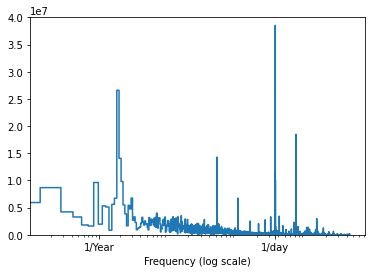

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

fft = tf.signal.rfft(load)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(load)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [4]:
f_per_year[np.argwhere(np.abs(fft) > 1e7).flatten()]

array([  0.        ,   1.95471468,   2.09433716,  52.21880642,
       364.27504266, 365.2524    , 366.22975734, 730.5048    ])

Create yearly, weekly, and daily signals.

In [10]:
import pandas as pd
day = 24*60*60
year = (365.2425)*day
timestamp_s = df.index.to_series().map(pd.Timestamp.timestamp)
df['Daily sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Daily cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Weekly sin'] = np.sin(timestamp_s * (2 * np.pi / (7*day)))
df['Weekly cos'] = np.cos(timestamp_s * (2 * np.pi / (7*day)))
df['Yearly sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Yearly cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

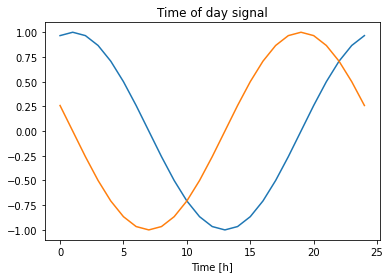

In [6]:
plt.plot(np.array(df['Daily sin'])[:25])
plt.plot(np.array(df['Daily cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [6]:
raw_data = df.to_numpy()
num_test_samples = num_val_samples = 365 * 24
num_train_samples = len(raw_data) - num_test_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [13]:
import numpy as np
from tensorflow import keras

sampling_rate = 1
sequence_length = 24*7
delay = sampling_rate * (sequence_length + 24 - 1) 

batch_size = 16 # hyperparameter
should_shuffle = True

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [14]:
from datetime import datetime
from keras import layers

def evaluate(model, optimizer="adamax", loss="mse", epochs=10, checkpoint_file=None):
    ts = datetime.now().strftime ("%Y%m%d_%H%M%S")
    checkpoint_file = checkpoint_file or f"load_prediction_{optimizer}_{loss}_{ts}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_file, monitor='val_mae', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)]
    model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    model = keras.models.load_model(checkpoint_file)
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:2f}")
    return history, checkpoint_file

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Dense(32, activation='leaky_relu')(inputs)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(32, activation='leaky_relu')(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

history, checkpoint_file = evaluate(model, epochs=250)

Epoch 1/250
2819/2819 [==============================] - 1090s 314ms/step - loss: 78613184.0000 - mae: 8414.9443 - val_loss: 11816600.0000 - val_mae: 3020.7122
Epoch 2/250
2819/2819 [==============================] - 1074s 381ms/step - loss: 4421194.5000 - mae: 1656.4369 - val_loss: 2996067.7500 - val_mae: 1424.7089
Epoch 3/250
2819/2819 [==============================] - 1088s 386ms/step - loss: 3193126.2500 - mae: 1433.1832 - val_loss: 2985806.5000 - val_mae: 1421.9149
Epoch 4/250
2819/2819 [==============================] - 1093s 388ms/step - loss: 3189031.7500 - mae: 1429.7233 - val_loss: 2989571.7500 - val_mae: 1422.9421
Epoch 5/250
2819/2819 [==============================] - 1108s 393ms/step - loss: 2992467.7500 - mae: 1381.8386 - val_loss: 1954471.7500 - val_mae: 1111.5404
Epoch 6/250
2819/2819 [==============================] - 1161s 412ms/step - loss: 1620537.5000 - mae: 988.7645 - val_loss: 697076.3125 - val_mae: 637.1161
Epoch 7/250
2819/2819 [==============================

In [11]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Dense(32, activation='leaky_relu')(inputs)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(32, activation='leaky_relu')(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

history, checkpoint_file = evaluate(model, epochs=250)

Epoch 1/250
1409/1409 [==============================] - 397s 172ms/step - loss: 111138584.0000 - mae: 10402.2520 - val_loss: 75863672.0000 - val_mae: 8551.7168
Epoch 2/250
1409/1409 [==============================] - 414s 294ms/step - loss: 49081228.0000 - mae: 6629.1812 - val_loss: 12722550.0000 - val_mae: 3163.5237
Epoch 3/250
1409/1409 [==============================] - 405s 288ms/step - loss: 5814383.5000 - mae: 1914.7860 - val_loss: 2934919.5000 - val_mae: 1407.7428
Epoch 4/250
1409/1409 [==============================] - 413s 293ms/step - loss: 3204364.5000 - mae: 1435.3265 - val_loss: 2963606.0000 - val_mae: 1415.6910
Epoch 5/250
1409/1409 [==============================] - 417s 296ms/step - loss: 3208495.2500 - mae: 1436.8074 - val_loss: 2975342.0000 - val_mae: 1418.9065
Epoch 6/250
1409/1409 [==============================] - 418s 297ms/step - loss: 3139615.0000 - mae: 1416.5593 - val_loss: 1628981.0000 - val_mae: 1006.3735
Epoch 7/250
1409/1409 [=============================

load_prediction_adamax_mse_20220505_175618.keras


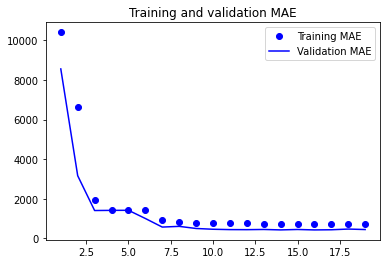

In [12]:
print(checkpoint_file)
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()